In [62]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import copy
from plotly import *
import plotly.graph_objects as go
import plotly.express as px
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import Angle
from astropy.time import Time

from config import *
pd.options.display.float_format = '{:.9f}'.format

In [63]:
with open(f'{name_pulsar}_start.par', 'r') as file:
    lines = file.readlines()

ra_label, *ra_coord = lines[1].split()
dec_label, *dec_coord = lines[2].split()
period_label, *start_period = lines[3].split()

coords = SkyCoord(
        ra_coord[0]
        + ' '
        + dec_coord[0],
        unit=(u.deg, u.deg))

ra_start = Angle(ra_coord[0], 'hour')
dec_start = copy(coords.dec)
freq_start = float(start_period[0])

In [64]:
p_coors = pd.read_csv(
    'res_iter_p_coords_1112.txt',
    sep='\s+',
    names=['Freq, s-1', 'RAJ', 'DECJ', 'STD_res, us'],
    dtype={'Freq, s-1': np.float64, 'RAJ': str, 'DECJ': str, 'STD_res, us': np.float64}
)
pd.options.display.float_format = '{:.10f}'.format

NameError: name 'x_val' is not defined

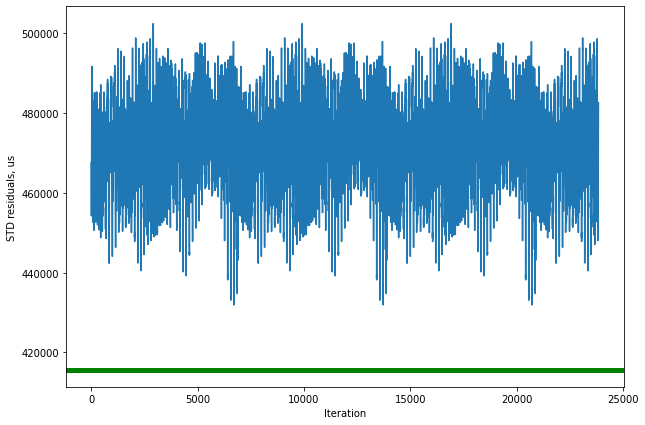

In [65]:
plt.figure(figsize=(10,7))
plt.xlabel('Iteration')
plt.ylabel('STD residuals, us')
plt.plot(p_coors['STD_res, us'])

for i in range(len(p_coors)):
    if p_coors['RAJ'][i] == ra_start.to_string(sep=":"):
        if p_coors['DECJ'][i] == dec_start.to_string(sep=":"):
            if p_coors['Freq, s-1'][i] == freq_start:
                x_val = i
                break

med_res_val = sum(list(p_coors['STD_res, us'])) / len(p_coors)
sigma = (sum(list(map(lambda x: (x - med_res_val) ** 2, list(p_coors['STD_res, us'])))) / len(p_coors)) ** 0.5
y_val = med_res_val - 5 * sigma


plt.axhline(y=y_val, xmin=0, xmax=1, color = 'g', linewidth = 5)
plt.axvline(x=x_val, ymin=0, ymax=1, color='r', linewidth  = 5)
#plt.savefig('res.png', format='png', dpi=150)
plt.show()

In [66]:
p_coors_s = p_coors.sort_values(by='STD_res, us', ascending=True).reset_index(drop=True)

In [68]:
p_coors_s

,"Freq, s-1",RAJ,DECJ,"STD_res, us"
0,0.6037044173,11:17:33.1826087,50:03:02.56027027,431918.9922171801
1,0.6037044173,11:17:33.1826087,50:03:02.56027027,431918.9939179939
2,0.6037044173,11:17:33.1826087,50:03:02.56027027,431918.9995000473
3,0.6037044173,11:17:33.1826087,50:02:38.23594595,431925.6922416443
4,0.6037044173,11:17:33.1826087,50:02:38.23594595,431925.6931785765
...,...,...,...,...
23841,0.6037044173,11:15:17.53043478,50:35:52.83054054,500313.7719756961
23842,0.6037044173,11:15:17.53043478,50:35:52.83054054,500313.7780649628
23843,0.6037044173,11:15:17.53043478,50:35:28.50621622,502471.3110233915
23844,0.6037044173,11:15:17.53043478,50:35:28.50621622,502471.3130775865


In [69]:
best_sol = pd.DataFrame(columns=[
    'Freq, s-1', 
    'RAJ',
    'DECJ',
    'STD_res, us'
])
tres = 500000
idx = 0
for i in range(len(p_coors_s)):
    if p_coors_s['STD_res, us'][i] > tres:
        continue
    if p_coors_s['Freq, s-1'][i] not in list(best_sol['Freq, s-1']):
        best_sol.loc[idx] = [
            np.float64(p_coors_s['Freq, s-1'][i]),
            p_coors_s['RAJ'][i],
            p_coors_s['DECJ'][i],
            p_coors_s['STD_res, us'][i]
        ]
        idx += 1

In [70]:
best_sol = best_sol.head(10)

In [71]:
best_sol

,"Freq, s-1",RAJ,DECJ,"STD_res, us"
0,0.6037044173,11:17:33.1826087,50:03:02.56027027,431918.9922171801
1,0.6037044173,11:17:33.1826087,50:03:02.56027027,431918.9939179939
2,0.6037044173,11:17:33.1826087,50:03:02.56027027,431918.9995000473
3,0.6037044173,11:14:56.66086957,50:41:33.37108108,440498.5687394661


In [61]:
x_list = []
y_list = []
z_list = []
for i in range(len(best_sol)):
    x_list.append(best_sol['RAJ'][i][:12])
    y_list.append(best_sol['DECJ'][i][:12])
    z_list.append(best_sol['Freq, s-1'][i])

my_dict = dict(sorted(dict(zip(y_list, x_list)).items(), key=lambda x: x[0]))
x_list = list(my_dict.values())
y_list = list(my_dict.keys())


df = pd.DataFrame({'ra': x_list, 'dec': y_list, 'freq': z_list})
fig = px.scatter_3d(df, x='ra', y='dec', z='freq')


for i in range(len(best_sol)):
    x_starts = best_sol['RAJ'][i][:12]
    y_starts = best_sol['DECJ'][i][:12]
    z_starts = best_sol['Freq, s-1'][i]
    line_x = go.Scatter3d(x = [x_starts, x_starts], y = [y_starts, y_starts], z = [z_starts, min(best_sol['Freq, s-1'])], mode='lines', marker=dict(color='blue'))
    line_y = go.Scatter3d(x = [x_starts, min(best_sol['RAJ'])[:12]], y = [y_starts, y_starts], z = [z_starts, z_starts], mode='lines', marker=dict(color='green'))
    line_z = go.Scatter3d(x = [x_starts, x_starts], y = [y_starts, min(best_sol['DECJ'])[:12]], z = [z_starts, z_starts], mode='lines', marker=dict(color='grey'))
    fig.add_trace(line_x)
    fig.add_trace(line_y)
    fig.add_trace(line_z)
start_point = go.Scatter3d(x = [ra_start.to_string(sep=":")], y = [dec_start.to_string(sep=":")], z = [freq_start], marker=dict(
        size=16,
        cmax=39,
        cmin=0,
        color='red'), mode = 'markers')
fig.add_trace(start_point)
line_x = go.Scatter3d(x = [x_start, x_start], y = [y_start, y_start], z = [z_start, min(best_sol['Freq, s-1'])], mode='lines', marker=dict(color='red'))
line_y = go.Scatter3d(x = [x_start, min(best_sol['RAJ'])[:12]], y = [y_start, y_start], z = [z_start, z_start], mode='lines', marker=dict(color='red'))
line_z = go.Scatter3d(x = [x_start, x_start], y = [y_start, min(best_sol['DECJ'])[:12]], z = [z_start, z_start], mode='lines', marker=dict(color='red'))
fig.add_trace(line_x)
fig.add_trace(line_y)
fig.add_trace(line_z)

offline.plot(fig, filename=f'./res_information_{name_pulsar}.html')

ValueError: All arrays must be of the same length

In [133]:
x_list = []
y_list = []
z_list = []
for i in range(len(best_sol)):
    x_list.append(best_sol['RAJ'][i][:12])
    y_list.append(best_sol['DECJ'][i][:12])
    z_list.append(best_sol['Freq, s-1'][i])
df = pd.DataFrame({'ra': x_list, 'dec': y_list, 'freq': z_list})
fig = px.scatter_3d(df, x='ra', y='dec', z='freq')
offline.plot(fig, filename=f'./res_information_{name_pulsar}.html')

'./res_information_1112.html'

In [141]:
'50:29:47.965' < '50:31:00.938'

True

In [51]:
x_list

['11:17:33.182', '11:17:33.182', '11:14:56.660']

In [52]:
y_list

['50:03:02.560', '50:03:02.560', '50:41:33.371']

In [55]:
dict(zip(y_list, x_list))

{'50:03:02.560': '11:17:33.182', '50:41:33.371': '11:14:56.660'}

In [59]:
my_dict = dict(sorted(dict(zip(y_list, x_list)).items(), key=lambda x: x[0]))
x_list = list(my_dict.values())
y_list = list(my_dict.keys())

In [60]:
x_list = list(my_dict.values())
y_list = list(my_dict.keys())